# Multilabel Classifier

# Reading and Preparing the Data

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

# Reading the data
data = pd.read_csv('C:/Users/jayac/OneDrive/Desktop/McGill/TextAnalytics/ProjectDataset/wine_data.csv')

# Overview by Wine Region

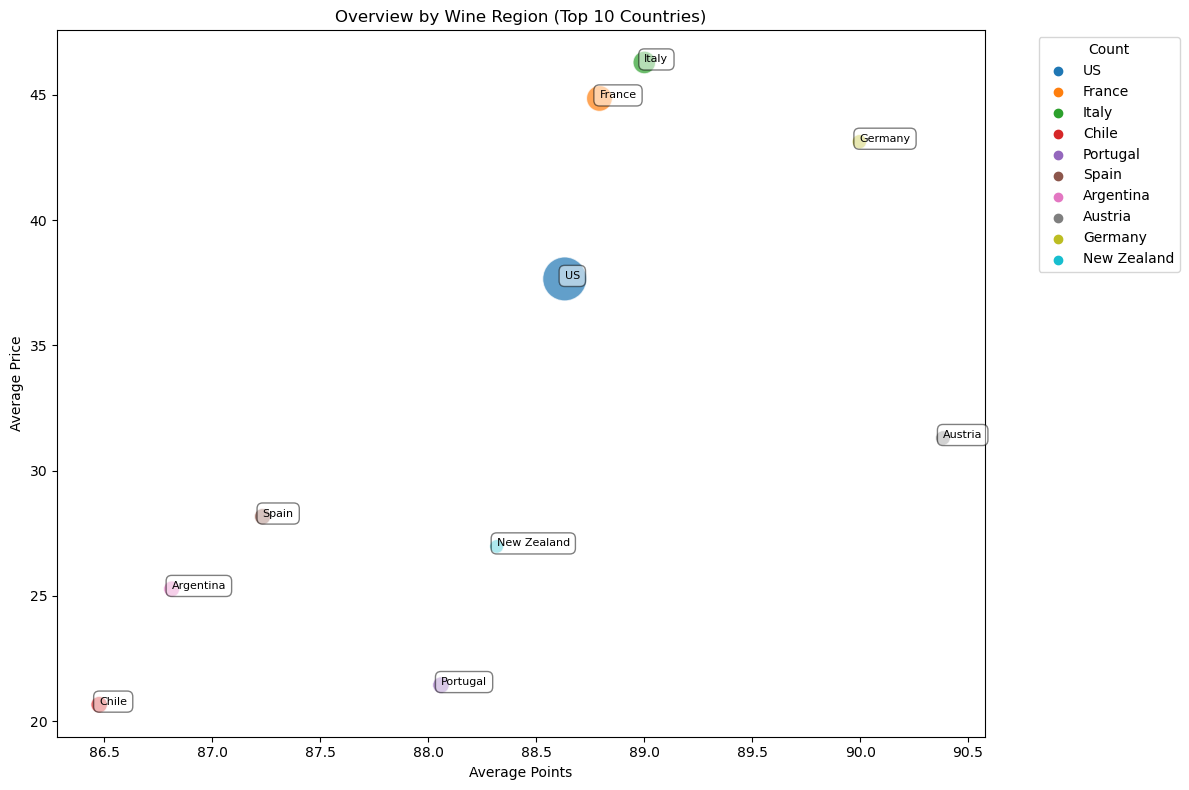

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregating data for countries
agg_data = data.groupby('country').agg(
    avg_points=('points', 'mean'),
    avg_price=('price', 'mean'),
    count=('country', 'size')
).reset_index()

# Selecting top 10 countries by count
top_countries = agg_data.nlargest(10, 'count')

# Plotting
plt.figure(figsize=(12, 8))
bubble_chart = sns.scatterplot(
    data=top_countries,
    x='avg_points',
    y='avg_price',
    size='count',
    hue='country',
    sizes=(100, 1000),  # Adjust the range of bubble sizes
    alpha=0.7
)

for i in range(top_countries.shape[0]):
    plt.text(
        x=top_countries.iloc[i]['avg_points'],
        y=top_countries.iloc[i]['avg_price'],
        s=top_countries.iloc[i]['country'],  # The text to be displayed
        fontdict=dict(color='black', size=8),  # Adjust text color and size
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5')  # Optional: add a background to the text for readability
    )

plt.title('Overview by Wine Region (Top 10 Countries)')
bubble_chart.set_xlabel('Average Points')
bubble_chart.set_ylabel('Average Price')

# Modify the legend
handles, labels = bubble_chart.get_legend_handles_labels()
# Adjust the handles/labels as needed to represent your data accurately
adjusted_handles = handles[1:11]  # This slices out the handles for the sizes
adjusted_labels = labels[1:11]  # Update these based on your actual size ranges

# Create new legend
plt.legend(adjusted_handles, adjusted_labels, title='Count', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
# Dropping unnecessary columns
columns_to_drop = ['region_2', 'taster_name', 'taster_twitter_handle', 'country', 'designation', 'points', 'price', 'province', 'region_1', 'title', 'winery']
data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Splitting the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in split.split(data, data["variety"]):
    train = data.loc[train_index]
    test = data.loc[test_index]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Preparing 'variety' column for multi-label binarization
train['variety'] = train['variety'].apply(lambda x: [x])
test['variety'] = test['variety'].apply(lambda x: [x])

# Checking for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


# Text Preprocessing

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Preprocessing the descriptions
stopword_list = stopwords.words('english')
ps = PorterStemmer()

def process_description(description):
    description = re.sub('[^a-zA-Z]', ' ', description)
    description = description.lower()
    description_words = description.split()
    description_words = [word for word in description_words if word not in stopword_list]
    description_words = [ps.stem(word) for word in description_words]
    return ' '.join(description_words)

train['description'] = train['description'].apply(process_description)
test['description'] = test['description'].apply(process_description)

# Preparing Data for Classification

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

# Setting up MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train['variety'])
Y_train = multilabel_binarizer.transform(train['variety'])
Y_test = multilabel_binarizer.transform(test['variety'])

# Vectorizing descriptions
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.description)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(test.description)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Training and Evaluating Classifiers

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score
import numpy as np

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, Y_test)))
    print("Hamming score: {}".format(hamming_score(y_pred, Y_test)))
    print("---")
    
# Training and evaluating multiple classifiers
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression(solver='saga', max_iter=1000) 

for classifier in [nb_clf, sgd, lr]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train_tfidf, Y_train)
    y_pred = clf.predict(X_test_tfidf)
    print_score(y_pred, classifier)

Clf:  MultinomialNB
Hamming loss: 0.03637835534725181
Hamming score: 0.0963996591393268
---
Clf:  SGDClassifier
Hamming loss: 0.03794631444397103
Hamming score: 0.054324669791222836
---
Clf:  LogisticRegression
Hamming loss: 0.023783553472518107
Hamming score: 0.49016474932537984
---


# Choosing Logistic Regression as the best Classifier

In [7]:
# Assuming X_train_tfidf and X_test_tfidf are sparse matrices
from scipy.sparse import vstack

# Combine the vectorized text data
X_combined_tfidf = vstack([X_train_tfidf, X_test_tfidf])

# Combine the labels
Y_combined = np.concatenate([Y_train, Y_test])

# Initialize and configure Logistic Regression with OneVsRestClassifier
lr_final = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
clf_final = OneVsRestClassifier(lr_final)

# Fit the model on the combined TF-IDF transformed data
clf_final.fit(X_combined_tfidf, Y_combined)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='saga'))